In [164]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, save_npz
from sklearn.metrics.pairwise import cosine_similarity
import random
import pickle
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
data = pd.read_pickle('/content/drive/Othercomputers/MyMacBookPro/capstone3/data.pkl')

In [ ]:
# Baseline model - recommend most popular songs
data['track_name'].value_counts()

Closer                                                       761
Home                                                         489
HUMBLE.                                                      470
Roses                                                        436
One Dance                                                    433
                                                            ... 
Ven y camina conmigo (feat. Pepe Aguilar) - MTV Unplugged      1
A Llorar a Otra Parte                                          1
Capricho Maldito                                               1
Night Research                                                 1
FOAD - Bonus Track                                             1
Name: track_name, Length: 132920, dtype: int64

In [ ]:
# Collaborative Recommender Model

In [ ]:
Create pivot table of songs in playlists
data['one'] = 1 # To have ones and zeros if the song is in the playlist
pivot = data.pivot_table(values='one', index='pid', columns='trackid', fill_value=0)
pivot.to_pickle('/content/drive/Othercomputers/MyMacBookPro/capstone3/pivot2.pkl') #Pickle
lst = pivot.columns # Pivot file is large, use just the song names and their inidices for later
with open("test.txt", "wb") as fp:   #Pickle
  pickle.dump(lst, fp)

In [ ]:
# Create sparse matrix for finding cosine similarity
sparse = csr_matrix(pivot.values)
save_npz('/content/drive/Othercomputers/MyMacBookPro/capstone3/sparse.npz', sparse) # Save
cos_sim = cosine_similarity(sparse)

In [ ]:
# Helper functions to get playlist name from index and vice versa
def find_p_name_from_index(index):
    return data[data.pid == index]["playlist_name"].values[0]
def find_index_from_p_name(p_name):
    return data[data.playlist_name == p_name]["pid"].values[0]

In [ ]:
# Function to find the names of most similar playlists from name
def similar_playlists_name(playlist_name, num_playlists):
  playlist_index = find_index_from_p_name(playlist_name)
  sim_playlists = list(enumerate(cos_sim[playlist_index]))
  sorted_similar_playlists = sorted(sim_playlists,key=lambda x:x[1],reverse=True)[1:]
  top_name = []
  for row in sorted_similar_playlists[:num_playlists]:
    top_name.append(data[data.pid == row[0]]["playlist_name"].values[0])
  return top_name

In [ ]:
# Test
similar_playlists_name('Throwbacks', 10)

['throwbacks',
 'THROWBACKS',
 "early 2000's",
 'throwback',
 'Throwback',
 'Throwback Jams',
 'throwbacks',
 'tbt',
 'Old songs',
 'Throwbacks :)']

In [181]:
# Function to find the indicies of most similar playlists from index
def similar_playlists_pid(playlist_index, num_playlists):
  sim_playlists = list(enumerate(cos_sim[playlist_index]))
  sorted_similar_playlists = sorted(sim_playlists,key=lambda x:x[1],reverse=True)[1:]
  print(sorted_similar_playlists)
  top_pid = []
  for row in sorted_similar_playlists[:num_playlists]:
    top_pid.append(row[0])
  return top_pid

In [170]:
# Test
similar_playlists_pid(0, 10)

[(6323, 0.3070317192431717), (9938, 0.2596602792348401), (4266, 0.25591842241754786), (262, 0.24852506087385426), (3978, 0.24325638628366394), (2304, 0.2306351210785384), (6056, 0.21948481531639952), (8528, 0.2167830364915252), (5665, 0.21606790785072139), (6141, 0.21354071087949109), (7475, 0.2081639979129019), (5401, 0.20649734343734497), (1247, 0.20367710313134688), (3732, 0.20227651440696268), (6044, 0.20083857810137354), (4854, 0.2005310331285175), (3644, 0.19666846491663878), (4175, 0.19352523826151122), (9715, 0.19274776986097064), (3736, 0.19264433665263106), (4151, 0.19099661819606822), (1174, 0.19041011485395867), (747, 0.18905258165371072), (8312, 0.18881372801234028), (9645, 0.18881372801234028), (2088, 0.18876296480991392), (1658, 0.18817858378979252), (9212, 0.18712029714127995), (4754, 0.18605909041238622), (7136, 0.18523964340873708), (5456, 0.18444084864196306), (9743, 0.18203641092364134), (2151, 0.1820178386223203), (9576, 0.1788072271430359), (9586, 0.17856322690429

In [ ]:
# Function to find the songs in the similar playlists that aren't in given playlist
def similar_playlists_songs(playlist_index, num_playlists):
  sim_playlists = list(enumerate(cos_sim[playlist_index]))
  sorted_similar_playlists = sorted(sim_playlists,key=lambda x:x[1],reverse=True)[1:]
  dif_songs = []
  for row in sorted_similar_playlists[:num_playlists]:
    dif = sparse[row[0]] - sparse[playlist_index]
    dif[dif==-1] = 0
    dif_indicies = dif.nonzero()
    dif_songs.append((row[0], pivot.columns[dif_indicies[1]]))
  return dif_songs

In [ ]:
# Test
similar_playlists_songs(0, 2)

[(6323, Index(['1, 2 Step - Don Candiani Reggaeton Mix', '7 Things',
         'American Boy (feat. Kanye West)', 'Battlefield', 'Beautiful',
         'Beautiful Girls', 'Because of You', 'Big Girls Don't Cry (Personal)',
         'Blah Blah Blah', 'Bleeding Love',
         ...
         'Too Little, Too Late - Radio Version', 'Touch My Body', 'Umbrella',
         'Unwritten', 'Wannabe - Radio Edit', 'We R Who We R', 'What the Hell',
         'When I Grow Up', 'With You', 'Womanizer'],
        dtype='object', name='track_name', length=105)),
 (9938,
  Index(['7 Things', 'Bad Day', 'Blah Blah Blah', 'Boom Boom Pow', 'Breakaway',
         'California Gurls - feat. Snoop Dogg', 'Call Me Maybe',
         'DJ Got Us Fallin' In Love', 'Dog Days Are Over', 'Don't Cha',
         'Don't Stop The Music', 'Down', 'Dynamite', 'Fergalicious',
         'Gives You Hell', 'Gold Digger', 'Gotta Go My Own Way',
         'I Gotta Feeling', 'I Kissed a Girl', 'Ignition - Remix', 'In My Head',
         'Just

In [ ]:
# Function to find the songs in the similar playlists that aren't in given playlist,
# ranked by how many other similar playlists they are in
def similar_playlists_songs_ranked(playlist_index, num_playlists):
  sim_playlists = list(enumerate(cos_sim[playlist_index]))
  sorted_similar_playlists = sorted(sim_playlists,key=lambda x:x[1],reverse=True)[1:]
  dif_songs = []
  for row in sorted_similar_playlists[:num_playlists]:
    dif = sparse[row[0]] - sparse[playlist_index]
    dif[dif==-1] = 0
    dif_indicies = dif.nonzero()
    dif_songs.append(dif_indicies[1])
  total = np.hstack(dif_songs)
  c = Counter(total)
  return c.most_common()

In [ ]:
# Test
similar_playlists_songs_ranked(0, 10)[:5] # Long list, shortened for look

[(12363, 7), (41169, 7), (47849, 7), (86164, 7), (108080, 7)]

In [157]:
# Final model - returns song names
def playlist_continuation(playlist_index, num_playlists):
    cos_sim = cosine_similarity(sparse)
    sim_playlists = list(enumerate(cos_sim[playlist_index]))
    sorted_similar_playlists = sorted(sim_playlists,key=lambda x:x[1],reverse=True)[1:]
    dif_songs = []
    for row in sorted_similar_playlists[:num_playlists]:
        dif = sparse[row[0]] - sparse[playlist_index]
        dif[dif==-1] = 0
        dif_indicies = dif.nonzero()
        dif_songs.append(dif_indicies[1])
    total = np.hstack(dif_songs)
    common = Counter(total).most_common(10)
    song_indicies_list = []
    for row in common:
      song_indicies_list.append(row[0])
      songs = []
      for index in song_indicies_list:
        songs.append(pivot.columns[index])
    return songs

In [158]:
# Test
playlist_continuation(0, 100)

['Hollaback Girl',
 'Fergalicious',
 'Umbrella',
 "Hips Don't Lie",
 'Kiss Me Thru The Phone',
 'Beautiful Girls',
 'Gold Digger',
 'Ignition - Remix',
 'One, Two Step',
 'Down']

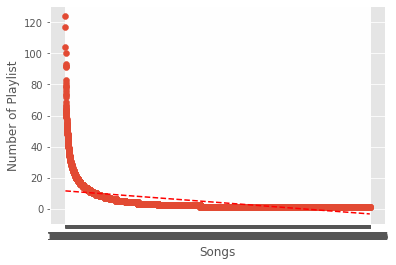

In [168]:
# Looking to find the point where songs are less important
ranked = similar_playlists_songs_ranked(0, 500)
# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
songs = list(zip(*ranked))[0]
count = list(zip(*ranked))[1]
x_pos = np.arange(len(songs)) 

# calculate slope and intercept for the linear trend line
slope, intercept = np.polyfit(x_pos, count, 1)
trendline = intercept + (slope * x_pos)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.scatter(x_pos, count)
plt.xticks(x_pos, songs) 
plt.ylabel('Number of Playlist')
plt.xlabel('Songs')
plt.show()

# A song being in 20 of the playlist seems to be the point that they get important

In [241]:
# Function to find the top playlists and their cosine similarity
def similar_playlists(playlist_index):
  sim_playlists = list(enumerate(cos_sim[playlist_index]))
  sorted_similar_playlists = sorted(sim_playlists,key=lambda x:x[1],reverse=True)[1:]
  top_pid = []
  sim = []
  for row in sorted_similar_playlists[:5000]:
    top_pid.append(row[0])
    sim.append(row[1])
  return top_pid, sim

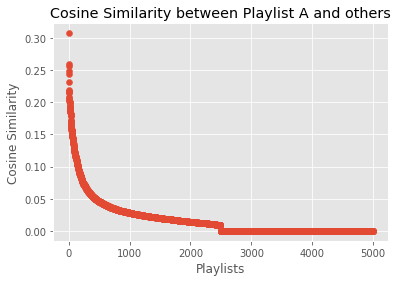

In [243]:
# Looking to find the point where similarity elbows

pid, sim = similar_playlists(0)
x_pos = np.arange(len(pid)) 
 
plt.scatter(x_pos, sim)
plt.ylabel('Cosine Similarity')
plt.xlabel('Playlists')
plt.title('Cosine Similarity between Playlist A and others')
plt.savefig('cosine_similarity.jpg', dpi=300);

# about < 500 for all